# 1. Подготовка обучающей выборки

In [1]:
import os
import sys

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from tqdm import tqdm

from pandarallel import pandarallel

import pymorphy2
import nltk
import pickle


import seaborn as sns
sns.set_style("whitegrid")

pd.set_option('display.max_colwidth', 255)
tqdm.pandas()
pandarallel.initialize(progress_bar=True, nb_workers=8, use_memory_fs=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## 1. Загрузка данных 

In [2]:
abbr = pd.read_csv("../input/abbr_dict.csv", sep="\t")
lenta = pd.read_csv("../input/lenta-ru-news.csv")

<ipython-input-2-c300cdb3f553>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  lenta = pd.read_csv("../input/lenta-ru-news.csv")


In [51]:
abbr

,abbr,desc,tags,norm_desc,desc_len,norm_abbr,abbr_len
0,ТММ,теория механизмов и машин,образование и наука,теория механизм и машина,4,тмм,1
1,ННИЦ алмазов,"Национальный научно-исследовательский центр алмазов, драгоценных камней и самородного золота","г. Якутск, образование и наука",национальный научно исследовательский центр алмаз драгоценный камень и самородный золото,10,нниц алмаз,2
2,БВВУ,Бакинское высшее военное училище,"воен., г. Баку, образование и наука",бакинский высокий военный училище,4,бвву,1
3,ВНИПИЭТ,Всероссийский научно-исследовательский и проектный институт энергетической техники,NaN,всероссийский научно исследовательский и проектный институт энергетический техника,8,внипиэт,1
4,СТЭФ,служба технической эксплуатации флота,техн.,служба технический эксплуатация флот,4,стэф,1
...,...,...,...,...,...,...,...
85530,КПЦ,Коммунистическая партия Цейлона,Коммунистическая партия Цейлона,коммунистический партия цейлон,3,кпц,1
85531,ФМП,факультет мировой политики,"<a href=""http://www.worldpolitics.redline.ru/"">http://www.worldpolitics.redline.ru/<span style=""visibility: hidden"">​</span><wbr/></a>",факультет мировой политика,3,фмп,1
85532,НИИАТ,Государственный научно-исследовательский институт автомобильного транспорта,Государственный научно-исследовательский институт автомобильного транспорта,государственный научно исследовательский институт автомобильный транспорт,6,нииат,1
85533,КЗП-,комплекс защиты пласта,,комплекс защита пласт,3,кзп,1


In [17]:
lenta.sample(3).head(3)

,url,title,text,topic,tags,date
297112,https://lenta.ru/news/2009/09/01/fish/,Сочинский океанариум обвинил таможенников в гибели 4 тысяч рыб,"Руководство сочинского океанариума обвинило таможенников в гибели более 4 тысяч экзотических рыб. Об этом 1 сентября сообщает агентство ""Интерфакс"" со ссылкой на главу службы океанариума по связям с общественностью Александра Фирсова. \r Пять тысяч эк...",Россия,Все,2009/09/01
268211,https://lenta.ru/news/2009/02/10/rentrak/,На российский кинорынок выходит крупнейший учетчик сборов,"Американская компания Rentrak Corporation, занимающаяся подсчетом кассовых сборов сетей кинотеатров, выходит на российский рынок. Как утверждает ""Коммерсант"", компания намерена предложить российским прокатчикам программное обеспечение, которое позволи...",Культура,Все,2009/02/10
273373,https://lenta.ru/news/2009/03/13/sharapova/,Шарапова проиграла первый матч после возвращения на корт,Бывшая первая ракетка мира Мария Шарапова провела первый официальный матч с августа 2008 года и потерпела поражение на турнире в американском Индиан-Уэллсе. В первом круге парных соревнований Шарапова вместе со своей соотечественницей Еленой Весниной ...,Спорт,Все,2009/03/13


## 2. Токенизация и лемматизация

Произведём предобработку входных данных с помощью токенизации и лематизации.

Для лематизации будем использовать только словарный анализатор для избежания искажения сокращений.

In [18]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
def tokenize(line):
    return tokenizer.tokenize(str(line).lower())

morph = pymorphy2.MorphAnalyzer(lang="ru", 
                                units=[pymorphy2.units.DictionaryAnalyzer()])
def normalize(word):
    parse_list = morph.parse(str(word))
    if parse_list != []:
        return parse_list[0].normal_form
    else:
        return word.lower()

def get_tokenized_normal_form(line):
    new_line_arr = []
    for token in tokenize(line):
        new_line_arr.append(normalize(token))
    return " ".join(new_line_arr)

In [19]:
abbr["norm_desc"] = abbr["desc"].parallel_apply(get_tokenized_normal_form)
abbr["desc_len"] = abbr["norm_desc"].str.split(" ").str.len()

In [20]:
abbr["norm_abbr"] = abbr["abbr"].parallel_apply(get_tokenized_normal_form)
abbr["abbr_len"] = abbr["norm_abbr"].str.split(" ").str.len()

In [21]:
lenta["norm_text"] = lenta["text"].parallel_apply(get_tokenized_normal_form)
lenta["text_len"] = lenta["norm_text"].str.split(" ").str.len()

## 3. Ограничение размеров 

### Сокращения 

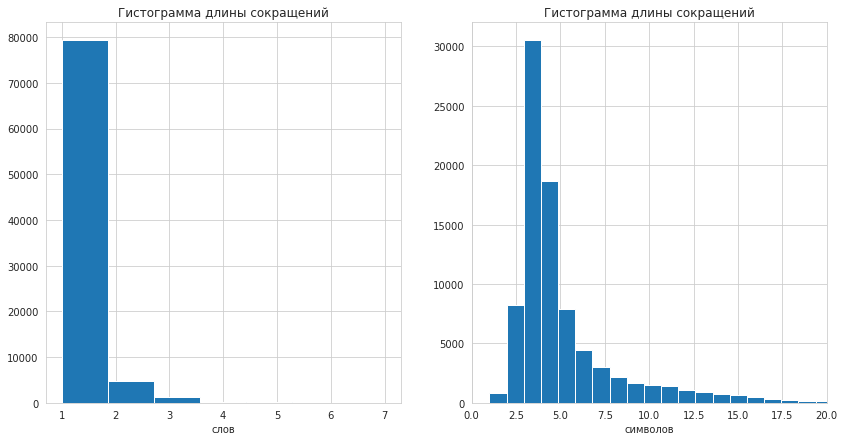

In [49]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
abbr.abbr_len.hist(bins=7)
plt.title("Гистограмма длины сокращений")
plt.xlabel("слов")

plt.subplot(1, 2, 2)
abbr.norm_abbr.str.len().hist(bins=30)
plt.xlim(0, 20)
plt.title("Гистограмма длины сокращений")
plt.xlabel("символов")
plt.show()

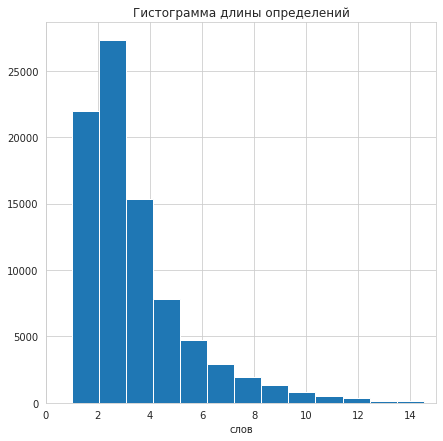

In [50]:
plt.figure(figsize=(7, 7))
abbr.desc_len.hist(bins=50)
plt.xlim(0, 15)
plt.title("Гистограмма длины определений")
plt.xlabel("слов")
plt.show()

In [52]:
abbr.norm_abbr.str.len().value_counts()

3     30508
4     18648
2      8226
5      7921
6      4426
7      2995
8      2143
9      1690
10     1539
11     1393
12     1117
13      870
1       812
14      782
15      683
16      503
17      336
18      267
19      185
20      153
21      113
22       72
23       52
24       35
26       25
25       19
27       11
28        8
29        2
30        1
Name: norm_abbr, dtype: int64

In [53]:
from nltk.corpus import stopwords
stopwords.words("russian")

ABBR_LEN_MAX = 1
DESC_LEN_MAX = 12
ABBR_CHAR_LEN_MIN = 2

print((abbr.abbr_len <= ABBR_LEN_MAX).sum() / abbr.shape[0])
print((abbr.desc_len <= DESC_LEN_MAX).sum() / abbr.shape[0])
print((abbr.norm_abbr.str.len() >= ABBR_CHAR_LEN_MIN).sum() / abbr.shape[0])
print((~abbr.norm_abbr.isin(stopwords.words("russian"))).sum() / abbr.shape[0])

abbr_filt = abbr[(abbr.abbr_len <= ABBR_LEN_MAX) & 
                 (abbr.desc_len <= DESC_LEN_MAX) &
                 (abbr.norm_abbr.str.len() >= ABBR_CHAR_LEN_MIN) &
                 (~abbr.norm_abbr.isin(stopwords.words("russian")))]
print(abbr_filt.shape[0] / abbr.shape[0])

0.926825276202724
0.994095984100076
0.990506810077746
0.9899222540480505
0.9076869117904951


### Тексты 

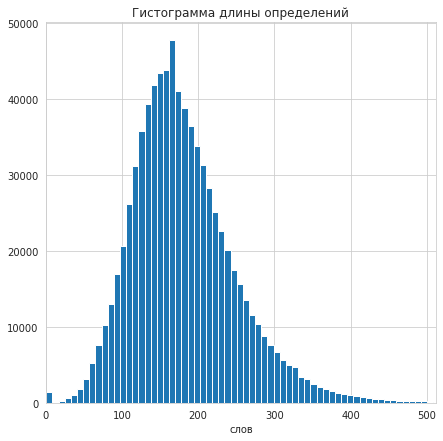

In [54]:
plt.figure(figsize=(7, 7))
lenta.text_len.hist(bins=1000)
plt.xlim(0, 512)
plt.title("Гистограмма длины текстов")
plt.xlabel("слов")
plt.show()

In [31]:
TEXT_LEN_MIN = 64
TEXT_LEN_MAX = 256

lenta_filt = lenta[lenta.text_len.between(TEXT_LEN_MIN, TEXT_LEN_MAX)]

print(lenta_filt.shape[0] / lenta.shape[0])

0.8563001342114298


## 3. Добавление статистики в сокращения 

In [36]:
REDUCE_COEF = 0.1

general_text = " ".join(lenta_filt.norm_text.sample(int(lenta_filt.shape[0] * REDUCE_COEF)).to_list())

abbr_filt["abbr_count"] = abbr_filt["norm_abbr"].parallel_apply(general_text.count)
abbr_filt["desc_count"] = abbr_filt["norm_desc"].parallel_apply(general_text.count)

<ipython-input-36-0c0b05adce7f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abbr_filt["abbr_count"] = abbr_filt["norm_abbr"].parallel_apply(general_text.count)


<ipython-input-36-0c0b05adce7f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abbr_filt["desc_count"] = abbr_filt["norm_desc"].parallel_apply(general_text.count)


In [49]:
ABBR_MIN_COUNT_IN_TEXTS = 10


print((abbr_filt.desc_count >= ABBR_MIN_COUNT_IN_TEXTS).sum() / abbr_filt.shape[0])

abbr_filt = abbr_filt[abbr_filt.desc_count >= ABBR_MIN_COUNT_IN_TEXTS]

0.07404783678306005


In [51]:
abbr_filt.head(20)

,abbr,desc,tags,norm_desc,desc_len,norm_abbr,abbr_len,abbr_count,desc_count
28,замгенпрокурора,заместитель генерального прокурора,None,заместитель генеральный прокурор,3,замгенпрокурора,1,29,43
41,...быт...,бытовой,None,бытовой,1,быт,1,121734,397
43,РС,реактивный снаряд,None,реактивный снаряд,2,рс,1,67397,28
50,МЦ,морская цель,морск.,морской цель,2,мц,1,394,10
125,СКОВС,Северо-Кавказский окружной военный суд,воен.,северо кавказский окружный военный суд,5,сковс,1,8383,17
169,ДМЗ,демилитаризованная зона,КНДР,демилитаризовать зона,2,дмз,1,4,40
207,МФО,международная финансовая организация,"организация, фин.",международный финансовый организация,3,мфо,1,595,19
209,РЖД,«Российские железные дороги»,"ж.-д., организация, РФ",российский железный дорога,3,ржд,1,6880,84
223,нем.,немецкий,None,немецкий,1,немой,1,2097,2365
225,валд.,валдайский,None,валдайский,1,валд,1,102,12


## 4. Сохранение 

In [52]:
abbr_filt.rename({"norm_abbr": "abbr_norm"}, axis=1, inplace=True)
abbr_filt.rename({"norm_desc": "desc_norm"}, axis=1, inplace=True)

abbr_filt.drop(["tags"], axis=1, inplace=True)
abbr_filt.drop_duplicates(["desc_norm", "abbr_norm"], inplace=True)
abbr_filt["abbr_id"] = np.arange(abbr_filt.shape[0])

abbr_filt.to_csv("../data/abbr.csv", index=False, header=True)

<ipython-input-52-15fa541e719f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abbr_filt.rename({"norm_abbr": "abbr_norm"}, axis=1, inplace=True)
<ipython-input-52-15fa541e719f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abbr_filt.rename({"norm_desc": "desc_norm"}, axis=1, inplace=True)
<ipython-input-52-15fa541e719f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abbr_filt.drop(["tags"], axis=1, inplace=True)
<ipython-input-

In [54]:
lenta_filt.rename({"norm_text": "text_norm"}, axis=1, inplace=True)

lenta_filt.drop(["url", "title", "topic", "tags", "date"], axis=1, inplace=True)

lenta_filt.to_csv("../data/lenta.csv", index=False, header=True)

<ipython-input-54-3205cf94b815>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lenta_filt.rename({"norm_text": "text_norm"}, axis=1, inplace=True)
<ipython-input-54-3205cf94b815>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lenta_filt.drop(["url", "title", "topic", "tags", "date"], axis=1, inplace=True)
